In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import os
import sys
import time
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from time import sleep

import tensorflow as tf
tf.enable_eager_execution()

from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, confusion_matrix

from imageloader import imagefolder

In [2]:
tf.Variable(True)

<tf.Variable 'Variable:0' shape=() dtype=bool, numpy=True>

## Flowers

https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz

In [3]:
import wget

dataurl = 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
basedir = './data/'

if not os.path.exists(basedir + 'flower_data.tar.gz'):
    wget.download(dataurl, basedir)

In [4]:
subclasses = ['1', '10', '20']
batchsize = 25

imgloader = imagefolder(basedir, [120, 120], 3)
imgloader.loadpaths('train', classes = subclasses)
imgloader.loadpaths('test', classes = subclasses)
imgloader.tfload(batchsize = batchsize, norm = True, onehot = True, shuffle = True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


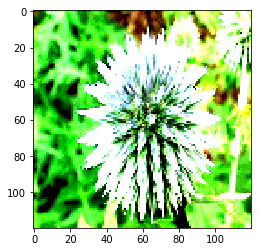

In [5]:
def plot_image(image):
    fig, ax = plt.subplots(1, 1)
    
    if image.shape[2] == 1:
        image = image[:, :, 0]
    ax.imshow(image.astype(int), cmap = 'gray')
    plt.show()

tfdata = imgloader.tfdict['test']
tfimg = list(enumerate(tfdata))[0][1][0].numpy()[0, :, :, :]
plot_image(200.*(tfimg + 1.) )

## Keras generic network

In [6]:
def Network(input_shape):
    initial = tf.keras.layers.Input(input_shape)
    state = tf.keras.layers.Conv2D(16, (4, 4))(initial)
    state = tf.keras.layers.PReLU()(state)
    state = tf.keras.layers.MaxPool2D((2, 2))(state)
    state = tf.keras.layers.Conv2D(32, (4, 4))(state)
    state = tf.keras.layers.PReLU()(state)
    state = tf.keras.layers.MaxPool2D((2, 2))(state)

    state = tf.keras.layers.Flatten()(state)
    state = tf.keras.layers.Dense(50)(state)
    state = tf.keras.layers.PReLU()(state)
    state = tf.keras.layers.Dropout(0.25)(state)
    state = tf.keras.layers.Dense(50)(state)
    state = tf.keras.layers.PReLU()(state)
    state = tf.keras.layers.Dropout(0.25)(state)
    state = tf.keras.layers.Dense(3)(state)
    state = tf.keras.layers.Softmax()(state)
    model = tf.keras.Model(inputs=initial, outputs=state)
    return model

In [7]:
convnet = Network((120, 120, 3))
convnet.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), \
                loss = 'categorical_crossentropy', metrics=['accuracy'])
convnet.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 117, 117, 16)      784       
_________________________________________________________________
p_re_lu (PReLU)              (None, 117, 117, 16)      219024    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 58, 58, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 32)        8224      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 55, 55, 32)        96800     
___________________________

In [8]:
steps = int(len(imgloader.pathdict['train'])/batchsize)
traindata = imgloader.tfdict['train'].repeat()
convnet.fit(traindata.make_one_shot_iterator(), \
            epochs=15, steps_per_epoch = steps, verbose=1)

Epoch 1/15
Instructions for updating:
Use tf.cast instead.
4/4 [==============================] - 3s 778ms/step - loss: 1.7722 - acc: 0.4000
Epoch 2/15
4/4 [==============================] - 2s 429ms/step - loss: 1.1780 - acc: 0.5814
Epoch 3/15
4/4 [==============================] - 2s 403ms/step - loss: 0.7259 - acc: 0.7558
Epoch 4/15
4/4 [==============================] - 2s 391ms/step - loss: 0.5509 - acc: 0.7907
Epoch 5/15
4/4 [==============================] - 1s 331ms/step - loss: 0.3994 - acc: 0.8372
Epoch 6/15
4/4 [==============================] - 2s 433ms/step - loss: 0.4207 - acc: 0.8400
Epoch 7/15
4/4 [==============================] - 1s 357ms/step - loss: 0.2815 - acc: 0.9186
Epoch 8/15
4/4 [==============================] - 1s 370ms/step - loss: 0.4672 - acc: 0.8256
Epoch 9/15
4/4 [==============================] - 1s 374ms/step - loss: 0.2810 - acc: 0.9186
Epoch 10/15
4/4 [==============================] - 1s 328ms/step - loss: 0.2664 - acc: 0.9070
Epoch 11/15
4/4 [====